# Simulation using CTA IRFs

- Intrinsic spectrum assumed to be extrapolation of the Fermi-LAT spectrum (showing example of `gammapy.catalog`)
- Add EBL absorpsion
- Simulated CTA DL4 data

In [94]:
%matplotlib inline

In [95]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
    EBLAbsorptionNormSpectralModel
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.data import Observation
from gammapy.datasets import MapDataset

from gammapy.catalog import SourceCatalog4FGL

## Use gammapy.catalog to find the Fermi spectrum
- see https://docs.gammapy.org/0.19/tutorials/api/catalog.html for details

In [96]:
catalog = SourceCatalog4FGL()
catalog.description

'LAT 8-year point source catalog'

In [97]:
## explore some other catalogs

In [98]:
#catalog.table

In [99]:
source = catalog["PKS 2155-304"]

In [100]:
print(source)


*** Basic info ***

Catalog row index (zero-based) : 5400
Source name          : 4FGL J2158.8-3013
Extended name        :                   
Associations     : PKS 2155-304, PKS 2155-304, 3FGL J2158.8-3013, 3FHL J2158.8-3013, J2157-3015, 3EG J2158-3023, EGR J2200-3015
ASSOC_PROB_BAY   : 1.000
ASSOC_PROB_LR    : 1.000
Class1           : bll  
Class2           :      
TeVCat flag      : P

*** Other info ***

Significance (100 MeV - 1 TeV)   : 224.639
Npred                            : 15833.8

Other flags          : 0

*** Position info ***

RA                   : 329.714 deg
DEC                  : -30.225 deg
GLON                 : 17.731 deg
GLAT                 : -52.243 deg

Semimajor (68%)      : 0.0049 deg
Semiminor (68%)      : 0.0049 deg
Position angle (68%) : -22.82 deg
Semimajor (95%)      : 0.0079 deg
Semiminor (95%)      : 0.0079 deg
Position angle (95%) : -22.82 deg
ROI number           : 1355

*** Spectral info ***

Spectrum type                                 : LogParab

In [101]:
source.row_index

5400

In [102]:
catalog.table[5400]

Source_Name,DataRelease,RAJ2000,DEJ2000,GLON,GLAT,Conf_68_SemiMajor,Conf_68_SemiMinor,Conf_68_PosAng,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Extended_Source_Name,Signif_Avg,Pivot_Energy,Flux1000,Unc_Flux1000,Energy_Flux100,Unc_Energy_Flux100,SpectrumType,PL_Flux_Density,Unc_PL_Flux_Density,PL_Index,Unc_PL_Index,LP_Flux_Density,Unc_LP_Flux_Density,LP_Index,Unc_LP_Index,LP_beta,Unc_LP_beta,LP_SigCurv,PLEC_Flux_Density,Unc_PLEC_Flux_Density,PLEC_Index,Unc_PLEC_Index,PLEC_Expfactor,Unc_PLEC_Expfactor,PLEC_Exp_Index,Unc_PLEC_Exp_Index,PLEC_SigCurv,Npred,Flux_Band [7],"Unc_Flux_Band [7,2]",nuFnu_Band [7],Sqrt_TS_Band [7],Variability_Index,Frac_Variability,Unc_Frac_Variability,Signif_Peak,Flux_Peak,Unc_Flux_Peak,Time_Peak,Peak_Interval,Flux_History [10],"Unc_Flux_History [10,2]",Sqrt_TS_History [10],ASSOC_FGL,ASSOC_FHL,ASSOC_GAM1,ASSOC_GAM2,ASSOC_GAM3,TEVCAT_FLAG,ASSOC_TEV,CLASS1,CLASS2,ASSOC1,ASSOC2,ASSOC_PROB_BAY,ASSOC_PROB_LR,RA_Counterpart,DEC_Counterpart,Unc_Counterpart,Flags
,,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,,,,MeV,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),erg / (cm2 s),,1 / (cm2 MeV s),1 / (cm2 MeV s),,,1 / (cm2 MeV s),1 / (cm2 MeV s),,,,,,1 / (cm2 MeV s),1 / (cm2 MeV s),,,,,,,,,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),,,,,,1 / (cm2 s),1 / (cm2 s),s,s,1 / (cm2 s),1 / (cm2 s),,,,,,,,,,,,,,,deg,deg,deg,
bytes18,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bytes18,float32,float32,float32,float32,float32,float32,bytes17,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,bytes18,bytes18,bytes18,bytes18,bytes18,bytes1,bytes26,bytes5,bytes5,bytes28,bytes26,float32,float32,float64,float64,float32,int16
4FGL J2158.8-3013,1,329.7141,-30.2251,17.7308,-52.2434,0.0049,0.0049,-22.820,0.0079,0.0079,-22.820,1355,,224.639,1118.64,2.0495e-08,2.3869e-10,2.1621e-10,3.2972e-12,LogParabola,1.3735e-11,1.4466e-13,1.8507,0.0071,1.4365e-11,1.6555e-13,1.7668,0.0116,0.0410,0.0041,5.024,1.3951e-11,1.5212e-13,1.7437,0.0127,0.00047,0.00005,0.6667,--,5.391,15833.77,8.811208e-08 .. 6.9656847e-10,-3.0399406e-08 .. 4.141124e-11,1.4376523e-11 .. 3.529928e-11,2.5337915 .. 54.02705,656.0535,0.2555,0.0610,98.236,1.7111846e-07,4.005396e-09,255223712.0,31332582.0,1.7111846e-07 .. 1.1275729e-07,-4.005396e-09 .. 3.5797774e-09,98.23613 .. 69.82156,3FGL J2158.8-3013,3FHL J2158.8-3013,J2157-3015,3EG J2158-3023,EGR J2200-3015,P,PKS 2155-304,bll,,PKS 2155-304,,1.0000,0.9997,329.7169,-30.2256,0.00000,0


In [103]:
source.position

<SkyCoord (ICRS): (ra, dec) in deg
    (329.71411133, -30.22509956)>

In [104]:
sky_model = source.sky_model()

In [105]:
print(sky_model)

SkyModel

  Name                      : 4FGL J2158.8-3013
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   1.44e-11   +/- 1.7e-13 1 / (cm2 MeV s)
    reference    (frozen)   :   1118.643       MeV         
    alpha                   :      1.767   +/-    0.01             
    beta                    :      0.041   +/-    0.00             
    lon_0                   :    329.714   +/-    0.00 deg         
    lat_0                   :    -30.225   +/-    0.00 deg         




<AxesSubplot:xlabel='Energy [MeV]', ylabel='e2dnde (erg / (cm2 s))'>

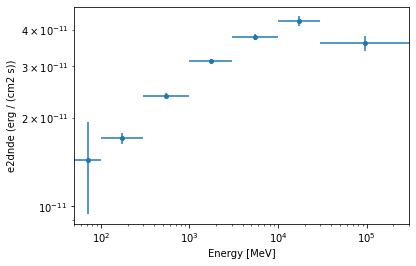

In [106]:
source.flux_points.plot(sed_type="e2dnde")

## Now, simulate for CTA using the above model

### Create a fake observation defining observation conditions

In [107]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [108]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 2.0 * u.hr
pointing = source.position

In [124]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=source.position,
    binsz=0.02,
    width=(3, 3),
    frame="icrs",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

### Define model to simulate the data

- intrinsic model from the 4FGL
- EBL model (see: https://docs.gammapy.org/0.19/modeling/gallery/spectral/plot_absorbed.html?highlight=ebl)

In [125]:
int_model = sky_model.spectral_model
print(int_model)

LogParabolaSpectralModel

  type      name     value         unit        error   min max frozen link
-------- --------- ---------- -------------- --------- --- --- ------ ----
spectral amplitude 1.4365e-11 cm-2 MeV-1 s-1 1.655e-13 nan nan  False     
spectral reference 1.1186e+03            MeV 0.000e+00 nan nan   True     
spectral     alpha 1.7668e+00                1.163e-02 nan nan  False     
spectral      beta 4.0969e-02                4.120e-03 nan nan  False     


In [126]:
redshift = 0.116
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

In [127]:
spectral_model = ebl * int_model
spatial_model = sky_model.spatial_model
model_simu = SkyModel(spectral_model=spectral_model, 
                      spatial_model=spatial_model,
                      name="model-simu")

In [128]:
bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

In [129]:
models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    alpha_norm   (frozen)   :      1.000                   
    redshift     (frozen)   :      0.116                   
    amplitude               :   1.44e-11   +/- 1.7e-13 1 / (cm2 MeV s)
    reference    (frozen)   :   1118.643       MeV         
    alpha                   :      1.767   +/-    0.01             
    beta                    :      0.041   +/-    0.00             
    lon_0                   :    329.714   +/-    0.00 deg         
    lat_0                   :    -30.225   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                   

### Now, perform a simulation

In [130]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.08
	duration          : 7200.00 s
	pointing (icrs)   : 329.7 deg, -30.2 deg

	deadtime fraction : 0.0%



In [131]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 0 
  Total background counts         : 52917.67
  Total excess counts             : -52917.67

  Predicted counts                : 52917.67
  Predicted background counts     : 52917.67
  Predicted excess counts         : nan

  Exposure min                    : 4.64e+07 m2 s
  Exposure max                    : 3.58e+10 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [132]:
#Add the model on the dataset and Poission fluctuate
dataset.models = models
dataset.fake()
# Do a print on the dataset - there is now a counts maps
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 55515 
  Total background counts         : 52917.67
  Total excess counts             : 2597.33

  Predicted counts                : 55665.85
  Predicted background counts     : 52917.67
  Predicted excess counts         : 2748.17

  Exposure min                    : 4.64e+07 m2 s
  Exposure max                    : 3.58e+10 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 152592.82

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
   

In [133]:
dataset.excess.smooth(0.05 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [134]:
dataset.counts

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (150, 150, 9)
	ndim  : 3
	unit  : 
	dtype : int64

<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>

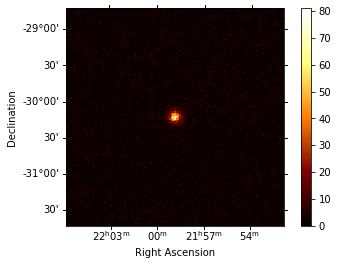

In [135]:
dataset.counts.sum_over_axes().plot(add_cbar=True)

In [136]:
dataset.counts.get_image_by_coord({"energy": "5 TeV"})

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (150, 150)
	ndim  : 2
	unit  : 
	dtype : int64

In [137]:
dataset.write("pks2155-simulated.fits.gz", overwrite=True)